In [5]:
import numpy as np
import h5py
import sys
import bisect

import matplotlib.pyplot as plt
import matplotlib.cm as cm

(120000, 9, 9)
(120000,)


<IPython.core.display.Javascript object>


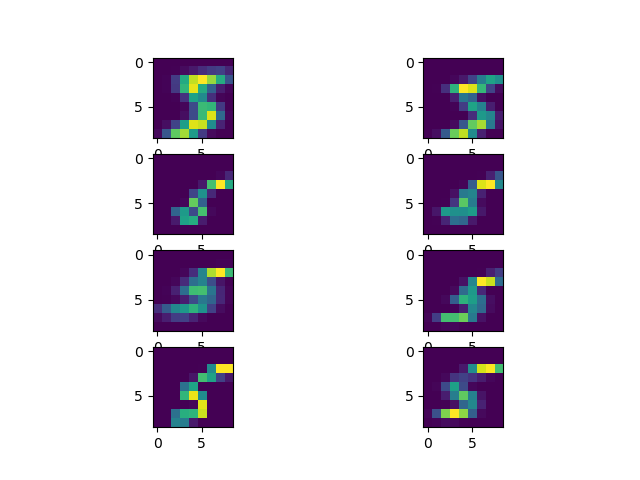

(10842, 9, 9)


In [189]:
f = h5py.File('./digits.h5')
images = f['images'].value
labels = f['labels'].value

f.close
print(images.shape)
print(labels.shape)

images[:8].shape

chosen_digit = 5
digit = images[np.where(labels==chosen_digit)]

fig, axes = plt.subplots(4,2)
for ax,im in zip(axes.flatten(),range(8)):
    ax.imshow(digit[im,:,:])
    
print(digit.shape)

In [174]:
def sample_naive_bayes(histograms, binning):
    """
    Generate new data from given histogram and binning information
    
    Parameters:
    -----------
        numpy.ndarray: histograms
        numpy.ndarray: binning
    
    Returns:
    --------
        numpy.ndarray: sampled_image
    """
    num_feat_dim = histograms.shape[0]
    
    pred_image = np.zeros(81)
    
    cum_histograms = np.cumsum(histograms,axis=1) #calculate cumulative probability distribution
    cum_histograms = (cum_histograms.T/cum_histograms[:,-1]).T # norm histogram
    #print(cum_histograms[0,:])
    selected_bins =  [bisect.bisect(cum_hist.flatten(),np.random.rand()) for cum_hist in cum_histograms]
    #print([((cum_hist.flatten()).shape) for cum_hist in cum_histograms])
    #print(selected_bins)
    pred_image = np.array([np.random.uniform(binning[pixel,bin_],binning[pixel,bin_+1]) for bin_,pixel in zip(selected_bins,range(len(selected_bins)))])
    
    
    return pred_image.reshape(9,9)

<IPython.core.display.Javascript object>


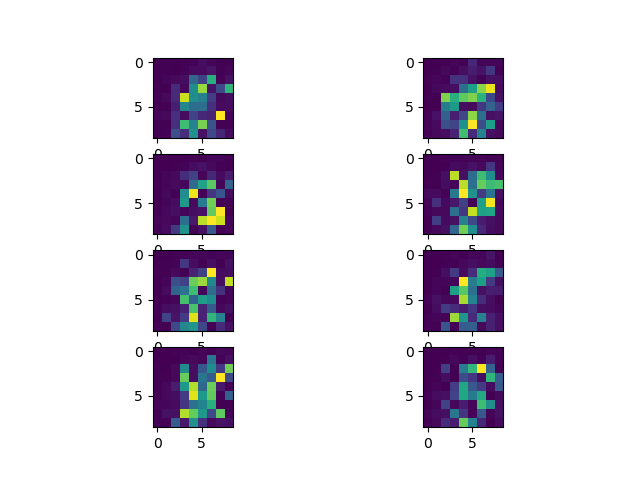

In [220]:
%matplotlib notebook
nb = NaiveBayesClassifier()
#flatten images:
digit_flat = digit.reshape(digit.shape[0],digit.shape[1]*digit.shape[2])


nb.train(digit_flat, np.ones(digit.shape[0],dtype=(int))*chosen_digit)

for _ in nb.histograms.values():
    histograms = np.squeeze(np.array([[__.heights] for __ in _]))  ### probability distr. for each feature dimension
    binning = np.squeeze(np.array([[__.bin_edges] for __ in _]))  ### bin edges for each feature dimension

sampled_images_nb = np.array([sample_naive_bayes(histograms,binning) for i in range(8)])
fig, axes = plt.subplots(4,2)
for ax,im in zip(axes.flatten(),range(8)):
    ax.imshow(sampled_images_nb[im,:,:])
    

/home/jan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.


<IPython.core.display.Javascript object>


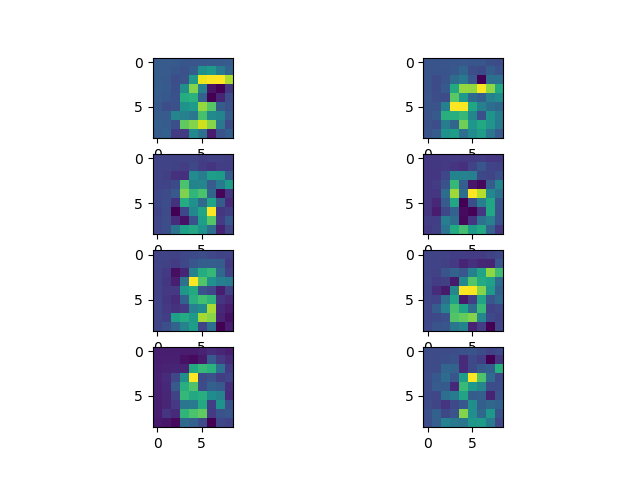

In [221]:
%matplotlib notebook
def fit_qda(training_features):
    """
    Fits D dimensional Gaussian to the given training data.
    
    
    Input N x D vector of training features
    Returns 2 x D matrix of means of the 2 classes, 2 x D x D array of the covariances"""
    
    def vec_generator(matrix):
        """ Returns one vector at a time"""
        for i in range(len(matrix[:,0])):
            yield matrix[i,:]
   
    mu = np.mean(training_features,axis=0)
    covmat = np.mean([np.outer(i,j) for i,j in zip(vec_generator(training_features-mu), vec_generator(training_features-mu))],axis=0)
    return mu, covmat

mu, covmat = fit_qda(digit_flat)
sampled_images_qda = np.array([np.random.multivariate_normal(mu,covmat).reshape(9,9) for i in range(8)])
fig, axes = plt.subplots(4,2)
for ax,im in zip(axes.flatten(),range(8)):
    ax.imshow(sampled_images_qda[im,:,:])

In [4]:

class Histogram(object):
    """Histogram.
    """

    def __init__(self, values):
        """Create a histogram for the given values using the Freedman-Diaconis rule for the bin width.

        :param values: the values from which the histogram will be computed
        """
        self.num_instances = len(values)

        # Get the number of bins.
        v_min, v_25, v_75, v_max = np.percentile(values, [0, 25, 75, 100])
        # freedman_diaconis_width = 2 * (v_75 - v_25) / (len(values) ** (1/3.0))
        freedman_diaconis_width = (v_max - v_min) / (len(values) ** (1/3.0))
        num_bins = int(round((v_max - v_min) / freedman_diaconis_width))
        assert num_bins > 0

        # Fill the bins.
        self.heights, self.bin_edges = np.histogram(values, bins=num_bins)

    def find_bin(self, value):
        """Find the bin index of the given value.

        :param value: some value
        :return: bin index
        """
        bin_index = bisect.bisect_left(self.bin_edges, value) - 1
        bin_index = max(bin_index, 0)
        bin_index = min(bin_index, len(self.heights)-1)
        return bin_index

    def bin_probability(self, bin_index):
        """Return the bin probability of the desired bin.

        :param bin_index: index of the bin
        :return: probability of the bin
        """
        assert 0 <= bin_index <= len(self.heights) - 1
        return self.heights[bin_index] / float(self.num_instances)

class NaiveBayesClassifier(object):
    """Naive Bayes classifier.
    """

    def __init__(self):
        self.num_instances = None  # Number of instances that were used in training.
        self.num_feats = None  # Number of features that were used in training.
        self.classes = None  # The classes that were found in training.
        self.histograms = {}  # Dict with histograms, key: class, value: list with histograms for all features.
        self.priors = {}  # Dict with priors, key: class, value: prior of the class.

    def train(self, train_x, train_y):
        """Train the classifier.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert train_x.shape[0] == len(train_y)
        self.num_instances = train_x.shape[0]
        self.num_feats = train_x.shape[1]
        self.classes = np.unique(train_y)

        # Create one histogram for each class and each feature.
        self.histograms.clear()
        self.priors.clear()
        for cl in self.classes:
            # Get the data of the current class.
            train_x_cl = [train_x[k] for k in range(self.num_instances) if train_y[k] == cl]
            num_instances_cl = len(train_x_cl)
            self.priors[cl] = num_instances_cl / float(self.num_instances)

            # Create one histogram per feature.
            self.histograms[cl] = []
            for i in range(self.num_feats):
                histo_points = [train_x_cl[k][i] for k in range(num_instances_cl)]
                self.histograms[cl].append(Histogram(histo_points))

    def probabilities_single(self, test_x):
        """Compute the class probabilities of a single instance.

        :param test_x: test x data of a single instance
        :return: probabilities of test_x for each class
        """
        assert len(test_x) == self.num_feats,\
            "NaiveBayesClassifier.probabilities_single(): Number of features in test and training must be the same."

        probs = {}
        for cl in self.classes:
            # Compute the likelihood.
            prob = self.priors[cl]
            for i in range(self.num_feats):
                # Find height of histogram bin with class cl that contains test_x[i].
                histo = self.histograms[cl][i]
                bin_index = histo.find_bin(test_x[i])
                prob *= histo.bin_probability(bin_index)
            probs[cl] = prob
        return probs

    def predict_single(self, test_x):
        """Predict the class of a single instance.

        :param test_x: test x data of a single instance
        :return: predicted class of test_x
        """
        probs = self.probabilities_single(test_x)
        max_cl = max(probs.keys(), key=lambda cl: probs[cl])
        return max_cl

    def predict(self, test_x):
        """Predict the classes of the given sample.

        :param test_x: test x data
        :return: predicted classes of test_x
        """
        assert test_x.shape[1] == self.num_feats,\
            "NaiveBayesClassifier.predict(): Number of features in test and training must be the same."
        return np.array([self.predict_single(test_x[i]) for i in range(test_x.shape[0])])

def print_error_rate(true_y, pred_y):
    """Prints the error rate of a prediction.

    :param true_y: true classes
    :param pred_y: predicted classes
    """
    assert len(true_y) == len(pred_y)
    correct = sum(1 for a, b in zip(true_y, pred_y) if a == b)
    total = len(true_y)
    rate = correct / float(total)
    print("The classification rate is %.02f (%d of %d were correct)." % (rate, correct, total))


def plot_compare(data_x, true_y, pred_y, title="Scatter Plot", legend=False, subplots=False):
    """Do a scatter plot of the data comparing the true and the predicted classes.

    Currently, only a 2 dimensional feature space and two classes are supported.
    :param data_x: n x d matrix with n instances of dimension d
    :param true_y: true classes
    :param pred_y: predicted classes
    :param title: title of the plot
    :param legend: show the legend
    :param subplots: use one subplot for each scatter plot
    """
    assert data_x.shape[0] == len(true_y) == len(pred_y)
    assert data_x.shape[1] == 2
    n = len(true_y)
    classes = np.unique(true_y)

    # Get the x and y coordinates of true/false positives/negatives.
    x_tp, y_tp = zip(*[(data_x[i, 0], data_x[i, 1]) for i in range(n)
                       if true_y[i] == pred_y[i] == classes[0]])
    x_tn, y_tn = zip(*[(data_x[i, 0], data_x[i, 1]) for i in range(n)
                       if true_y[i] == pred_y[i] == classes[1]])
    x_fp, y_fp = zip(*[(data_x[i, 0], data_x[i, 1]) for i in range(n)
                       if true_y[i] != pred_y[i] and pred_y[i] == classes[0]])
    x_fn, y_fn = zip(*[(data_x[i, 0], data_x[i, 1]) for i in range(n)
                       if true_y[i] != pred_y[i] and pred_y[i] == classes[1]])

    # Show the scatter plot.
    size = 20
    if subplots:
        # Use four subplots.
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (9,6))
        ax1.scatter(x_tp, y_tp, marker="x", c="b", s=size, label="tp")
        ax1.set_title("True positives")
        ax2.scatter(x_tn, y_tn, marker="o", c="b", s=size, label="tn")
        ax2.set_title("True negatives")
        ax3.scatter(x_fp, y_fp, marker="x", c="r", s=size, label="fp")
        ax3.set_title("False positives")
        ax4.scatter(x_fn, y_fn, marker="o", c="r", s=size, label="fn")
        ax4.set_title("False negatives")
        fig.tight_layout()
    else:
        # Plot all data in one diagram.
        plt.figure(figsize = (9,5))
        plt.title(title)
        plt.xlabel("First feature")
        plt.ylabel("Second feature")
        plt.scatter(x_tp, y_tp, marker="x", c="b", s=size, label="tp")
        plt.scatter(x_tn, y_tn, marker="o", c="b", s=size, label="tn")
        plt.scatter(x_fp, y_fp, marker="x", c="r", s=size, label="fp")
        plt.scatter(x_fn, y_fn, marker="o", c="r", s=size, label="fn")
        if legend:
            plt.legend(["tp", "tn", "fp", "fn"])
    plt.show()

# load digits data set
from sklearn.datasets import load_digits
from sklearn import model_selection

digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# extract only 3s and 9s
data_39 = data[np.logical_or(3 == target, 9 == target)]
target_39 = target[np.logical_or(3 == target, 9 == target)]

# function to reduce data set to two dimensions
def reduce_dim(x):
    feature1 = x[:, 26:27]
    feature2 = x[:, 22:23]
    
    reduced_x = np.concatenate([feature1, feature2], axis = 1)
    assert reduced_x.shape == (x.shape[0], 2)
    
    return reduced_x

reduced_data_39 = reduce_dim(data_39)

# split into train and test data
X_train, X_test, y_train , y_test =\
    model_selection.train_test_split(reduced_data_39, target_39, test_size = 0.4, random_state = 0)
print(X_train.shape, X_test.shape)

nb = NaiveBayesClassifier()

nb.train(X_train, y_train)
y_pred = nb.predict(X_test)

print_error_rate(y_test, y_pred)
#plot_compare(X_test, y_test, y_pred)
#plot_compare(X_test, y_test, y_pred, subplots = True)




(217, 2) (146, 2)
The classification rate is 0.85 (124 of 146 were correct).
